In [ ]:
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
data = pd.read_csv("EURJPY=X.csv")
data


,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-04-15,140.768997,140.875000,140.246002,140.789993,140.789993,0.0
1,2014-04-16,140.682007,141.731995,140.682007,140.686005,140.686005,0.0
2,2014-04-17,141.261002,141.610992,140.994995,141.279999,141.279999,0.0
3,2014-04-18,141.492996,141.619995,141.371002,141.485992,141.485992,0.0
4,2014-04-21,141.669998,141.817993,141.399994,141.669006,141.669006,0.0
...,...,...,...,...,...,...,...
2605,2024-04-09,164.921997,165.160995,164.557007,164.921997,164.921997,0.0
2606,2024-04-10,164.802002,164.975998,164.070007,164.802002,164.802002,0.0
2607,2024-04-11,164.292007,164.682007,163.951004,164.292007,164.292007,0.0
2608,2024-04-12,164.317001,164.376999,162.311005,164.317001,164.317001,0.0


In [ ]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2610 entries, 0 to 2609
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2610 non-null   object 
 1   Open       2607 non-null   float64
 2   High       2607 non-null   float64
 3   Low        2607 non-null   float64
 4   Close      2607 non-null   float64
 5   Adj Close  2607 non-null   float64
 6   Volume     2607 non-null   float64
dtypes: float64(6), object(1)
memory usage: 142.9+ KB


In [ ]:
# Preprocessing: remove missing values and select relevant features
#data = data.dropna()


In [ ]:
#data=data['Close'].dropna()


In [5]:
from sklearn.impute import SimpleImputer
# Prepare data
X = data[['Open', 'High', 'Low', 'Close','Volume']].values
y = np.sign(data['Close'].diff())
y



0       NaN
1       1.0
2      -1.0
3      -1.0
4      -1.0
       ... 
2605   -1.0
2606   -1.0
2607   -1.0
2608    1.0
2609   -1.0
Name: Close, Length: 2610, dtype: float64

In [ ]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(strategy='most_frequent')
y = imp.fit_transform(y.values.reshape(-1, 1))


In [7]:
from sklearn.svm import SVC
import numpy as np
# Preprocess data
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Feature engineering
X = np.append(X, np.array(data['Volume']).reshape(-1, 1), axis=1)
X = np.append(X, np.array(data['Open'].diff()).reshape(-1, 1), axis=1)
X = np.append(X, np.array(data['High'].diff()).reshape(-1, 1), axis=1)
X = np.append(X, np.array(data['Low'].diff()).reshape(-1, 1), axis=1)
X = np.append(X, np.array(data['Close'].diff()).reshape(-1, 1), axis=1)

from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='median')
X = imp.fit_transform(X)

# Assume X and y have already been defined and preprocessed
# Reshape y to have a shape of (n_samples, )
y = y.ravel()

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter tuning
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf', 'linear']}
grid_search = GridSearchCV(svm.SVC(), param_grid, cv=5, scoring='accuracy',error_score='raise')
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, error_score='raise', estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'linear']},
             scoring='accuracy')

In [8]:
from sklearn.ensemble import BaggingClassifier
# Train SVM classifier with best hyperparameters
clf = svm.SVC(C=grid_search.best_params_['C'], gamma=grid_search.best_params_['gamma'], kernel=grid_search.best_params_['kernel'])
#clf.fit(X_train, y_train)

# Use bagging to reduce overfitting
bagging = BaggingClassifier(clf, n_estimators=100, max_samples=0.8, max_features=1.0)
bagging.fit(X_train, y_train)

# Predict directional movement
#y_pred = clf.predict(X_test)
y_pred = bagging.predict(X_test)

# Calculate accuracy and print classification report
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('\nClassification Report:\n', classification_report(y_test, y_pred, zero_division=1))
# Print the best hyperparameters and model
print("Best Hyperparameters:")
print(grid_search.best_params_)
print("\nBest Model:")
print(clf)


Accuracy: 0.9942528735632183

Classification Report:
               precision    recall  f1-score   support

        -1.0       1.00      0.99      0.99       269
         0.0       1.00      0.00      0.00         1
         1.0       0.99      1.00      1.00       252

    accuracy                           0.99       522
   macro avg       1.00      0.66      0.66       522
weighted avg       0.99      0.99      0.99       522

Best Hyperparameters:
{'C': 100, 'gamma': 1, 'kernel': 'linear'}

Best Model:
SVC(C=100, gamma=1, kernel='linear')


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
# Compute the cross-validation score
scores = cross_val_score(clf, X, y, cv=5)

# Print the mean and standard deviation of the scores
print("Cross-validation scores:", scores)
print("Mean score:", np.mean(scores))
print("Standard deviation:", np.std(scores))


Cross-validation scores: [0.99616858 0.98659004 0.99233716 0.98850575 0.99042146]
Mean score: 0.9908045977011494
Standard deviation: 0.003295910064000998


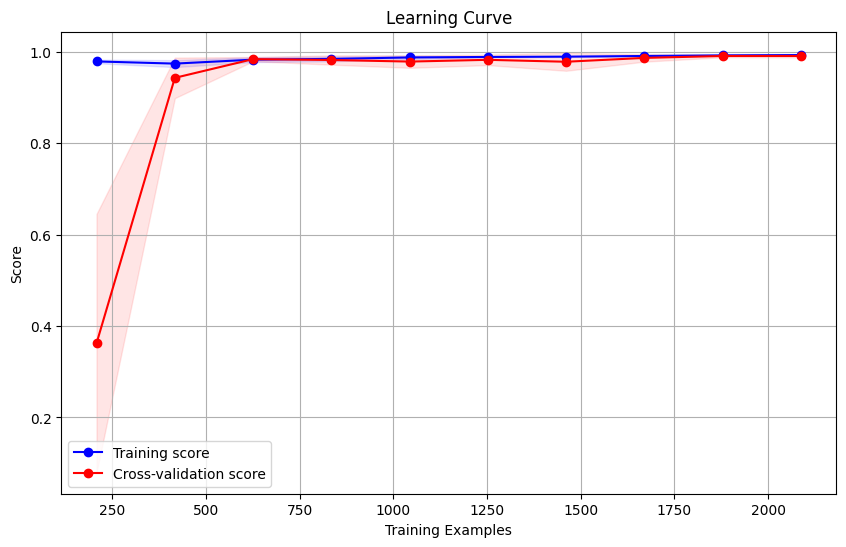

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Assuming best_model is already defined and X, y are the features and labels

# Define the learning curve parameters
train_sizes, train_scores, test_scores = learning_curve(clf, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate mean and standard deviation of training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="b")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="r")
plt.plot(train_sizes, train_mean, 'o-', color="b", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="r", label="Cross-validation score")
plt.title("Learning Curve")
plt.xlabel("Training Examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid(True)
plt.show()


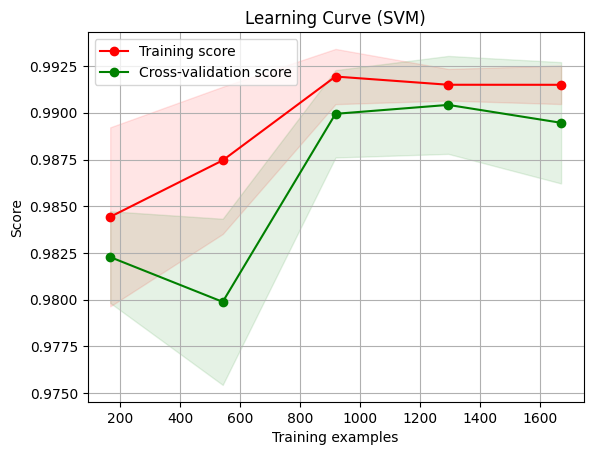

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC

# Define a function to plot the learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Train SVM classifier with best hyperparameters
clf = SVC(C=grid_search.best_params_['C'], gamma=grid_search.best_params_['gamma'], kernel='linear')
clf.fit(X_train, y_train)

# Plot learning curve
title = "Learning Curve (SVM)"
plot_learning_curve(clf, title, X_train, y_train, cv=None, n_jobs=-1)

plt.show()


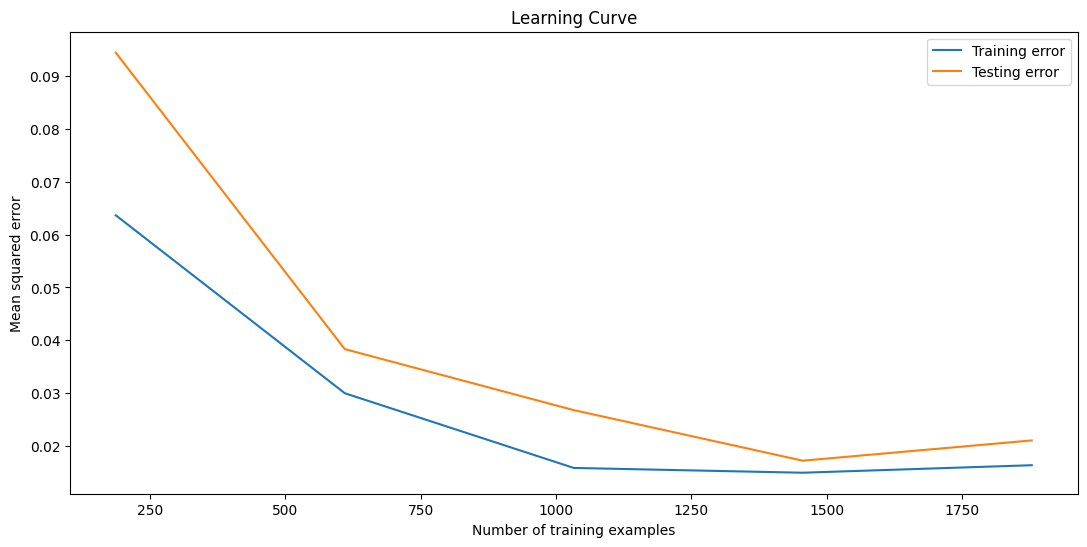

In [ ]:
# Calculate learning curve
train_sizes, train_scores, test_scores = learning_curve(clf, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

# Calculate mean training and testing error
train_errors = -train_scores.mean(axis=1)
test_errors = -test_scores.mean(axis=1)

# Plot learning curve
plt.figure(figsize=(13, 6))
plt.plot(train_sizes, train_errors, label='Training error')
plt.plot(train_sizes, test_errors, label='Testing error')
plt.xlabel('Number of training examples')
plt.ylabel('Mean squared error')
plt.title('Learning Curve')
plt.legend()
plt.grid(False)
plt.show()


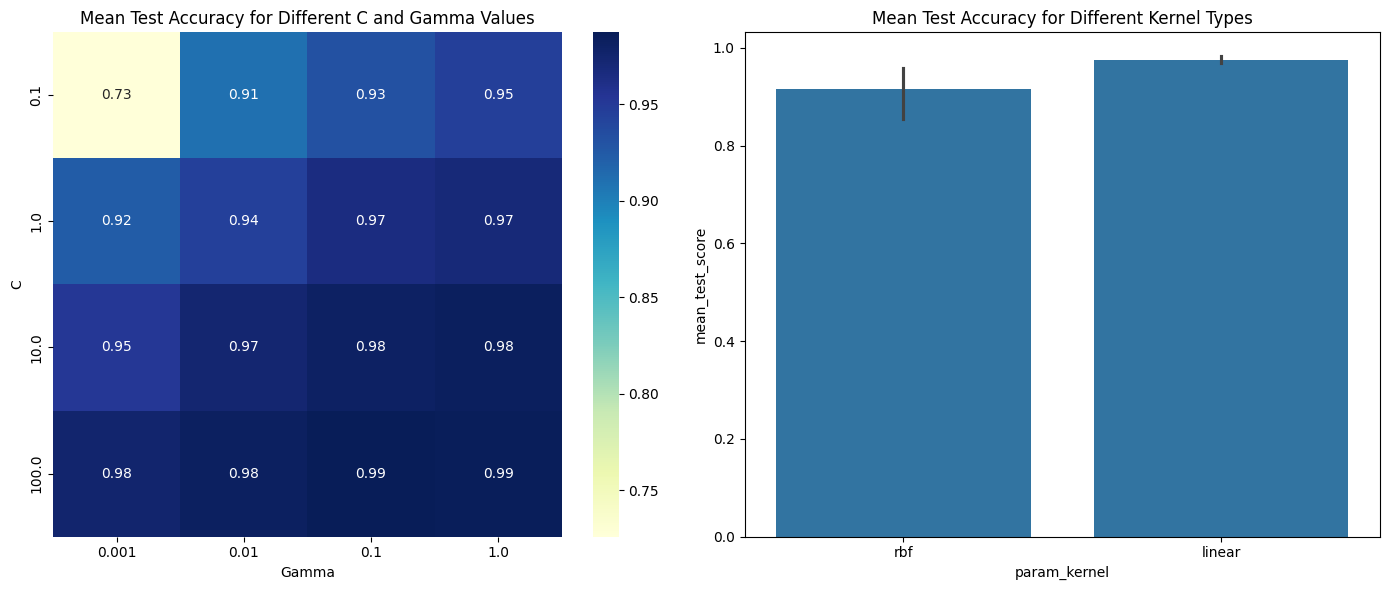

In [ ]:
# Extract grid search results
results = pd.DataFrame(grid_search.cv_results_)

# Plot grid search results for different hyperparameters
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot mean test scores for different values of C and gamma
sns.heatmap(results.pivot_table(index='param_C', columns='param_gamma', values='mean_test_score'), annot=True, cmap="YlGnBu", ax=axs[0])
axs[0].set_title('Mean Test Accuracy for Different C and Gamma Values')
axs[0].set_xlabel('Gamma')
axs[0].set_ylabel('C')

# Plot mean test scores for different kernel types
sns.barplot(x='param_kernel', y='mean_test_score', data=results, ax=axs[1])
axs[1].set_title('Mean Test Accuracy for Different Kernel Types')

plt.tight_layout()
plt.show()


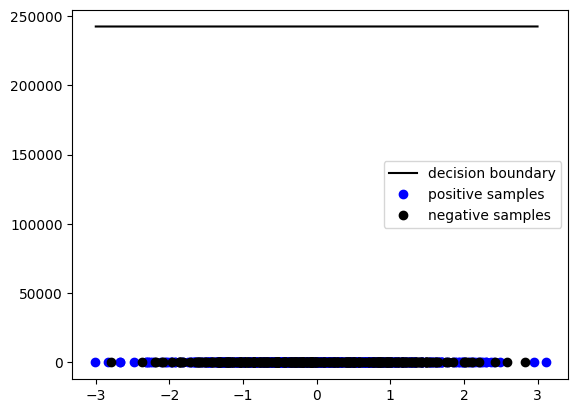

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm

# Generate some data
X = np.random.randn(1000, 2)
y = np.sign(np.random.randn(1000) + 0.5)

# Train an SVM classifier
clf = svm.SVC(kernel='linear')
clf.fit(X, y)

# Plot the decision boundary
x1 = np.linspace(-3, 3, 100)
x2 = -(clf.coef_[0][0] * x1 + clf.intercept_[0]) / clf.coef_[0][1]

plt.plot(x1, x2, 'k-', label='decision boundary')
plt.plot(X[:, 0][y==1], X[:, 1][y==1], 'bo', label='positive samples')
plt.plot(X[:, 0][y==-1], X[:, 1][y==-1], 'ko', label='negative samples')
plt.legend()
plt.show()
